In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from rdkit import Chem, RDLogger, DataStructs
from rdkit.Chem import rdFingerprintGenerator
from rdkit.ML.Cluster import Butina

RDLogger.DisableLog("rdApp.warning")

In [3]:
data = pd.read_csv("all_chem_df.csv")

data["tags"] = data["tags"].fillna("").str.split()
data = data.drop(["image_name", "Col3"], axis=1)
data = data[sorted(data.columns)]

data = data.explode("tags")
data

,smiles,tags
0,CC(=O)NC1C(O)OC(CO)C(O)C1O,dermatologic
1,CCC[C@@]1(CCc2ccccc2)CC(O)=C([C@H](CC)c2cccc(N...,antiinfective
2,CCCCC(C)C(=O)OC1C(C)C(CC)OC2(CC3CC(C/C=C(\C)CC...,antiinfective
3,COc1cc2c(c(OC)c1OC)-c1c(cc3c(c1OC)OCO3)C[C@H](...,antineoplastic
4,CC(=O)N[C@@H](CS)C(=O)[O-],antiinfective
...,...,...
8331,CC(=O)Oc1ccccc1C(=O)O.OCCN(CCO)c1nc(N2CCCCC2)c...,hematologic
8332,C=CO.C=O,hematologic
8333,CC1(C)SC2[C@H](NC(=O)[C@H](N)c3ccccc3)C(=O)N2[...,antiinfective
8334,COCCCOc1ccnc(C[S@@](=O)c2nc3ccccc3[nH]2)c1C,gastrointestinal


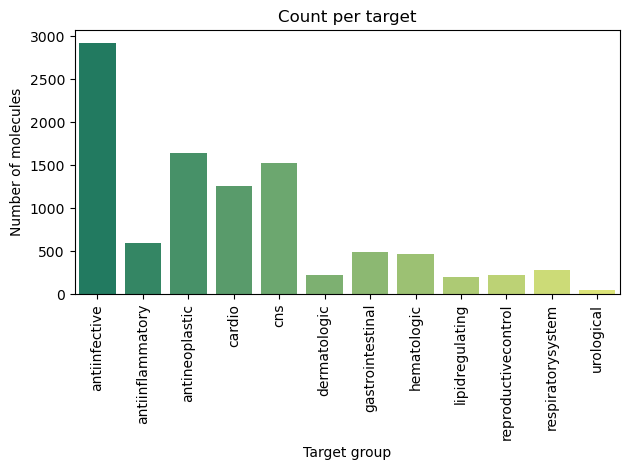

In [4]:
counts = data.groupby("tags")["smiles"].count().reset_index(name="n")

sns.barplot(data=counts, x="tags", y="n", palette="summer", hue="tags")
plt.ylabel("Number of molecules")
plt.xlabel("Target group")
plt.title("Count per target")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

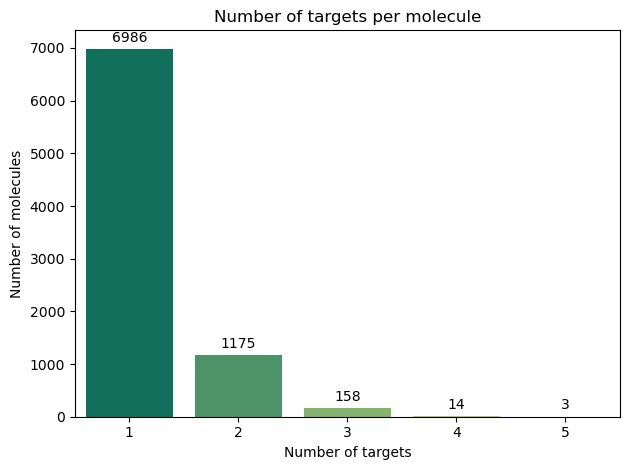

In [5]:
target_counts = (data.groupby("smiles")["tags"].nunique().value_counts().sort_index()).to_frame().reset_index()

sns.barplot(data=target_counts, x="tags", y="count", palette="summer", hue="tags")

for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt="%.0f", padding=3)
    
plt.legend([], [], frameon=False)
plt.ylabel("Number of molecules")
plt.xlabel("Number of targets")
plt.title("Number of targets per molecule")
plt.tight_layout()
plt.show()

Canonizing SMILES

In [6]:
def canonize(mol):
    return Chem.MolToSmiles(Chem.MolFromSmiles(mol), isomericSmiles=True, canonical=True)

data["canon_smiles"] = data["smiles"].apply(canonize)

Applying descriptors

In [7]:
from rdkit.Chem import Descriptors

data["mol"] = data["canon_smiles"].apply(lambda x: Chem.MolFromSmiles(x)) 
data["mol"] = data["mol"].apply(lambda x: Chem.AddHs(x))

data["num_of_atoms"] = data["mol"].apply(lambda x: x.GetNumAtoms())

data["num_of_heavy_atoms"] = data["mol"].apply(lambda x: x.GetNumHeavyAtoms())

data["TPSA"] = data["mol"].apply(lambda x: round(Descriptors.TPSA(x), 2))

data["exact_mol_wt"] = data["mol"].apply(lambda x: round(Descriptors.ExactMolWt(x), 2))

data["h_d"] = data["mol"].apply(lambda x: Descriptors.NumHDonors(x))

data["h_a"] = data["mol"].apply(lambda x: Descriptors.NumHAcceptors(x))

data["log_p"] = data["mol"].apply(lambda x: round(Descriptors.MolLogP(x), 2))

In [8]:
data.describe()

,num_of_atoms,num_of_heavy_atoms,TPSA,exact_mol_wt,h_d,h_a,log_p
count,9881.000000,9881.000000,9881.000000,9881.000000,9881.000000,9881.000000,9881.000000
mean,66.234389,33.821779,132.360659,484.319368,3.339743,7.818035,1.950855
std,43.501297,21.487481,122.219427,305.521675,4.094092,6.300318,3.337509
min,1.000000,1.000000,0.000000,20.020000,0.000000,0.000000,-26.050000
25%,38.000000,20.000000,57.530000,293.090000,1.000000,4.000000,0.370000
50%,54.000000,28.000000,95.940000,398.200000,2.000000,6.000000,2.320000
75%,80.000000,41.000000,165.920000,581.270000,4.000000,10.000000,3.900000
max,413.000000,221.000000,1247.650000,3045.360000,44.000000,81.000000,22.430000


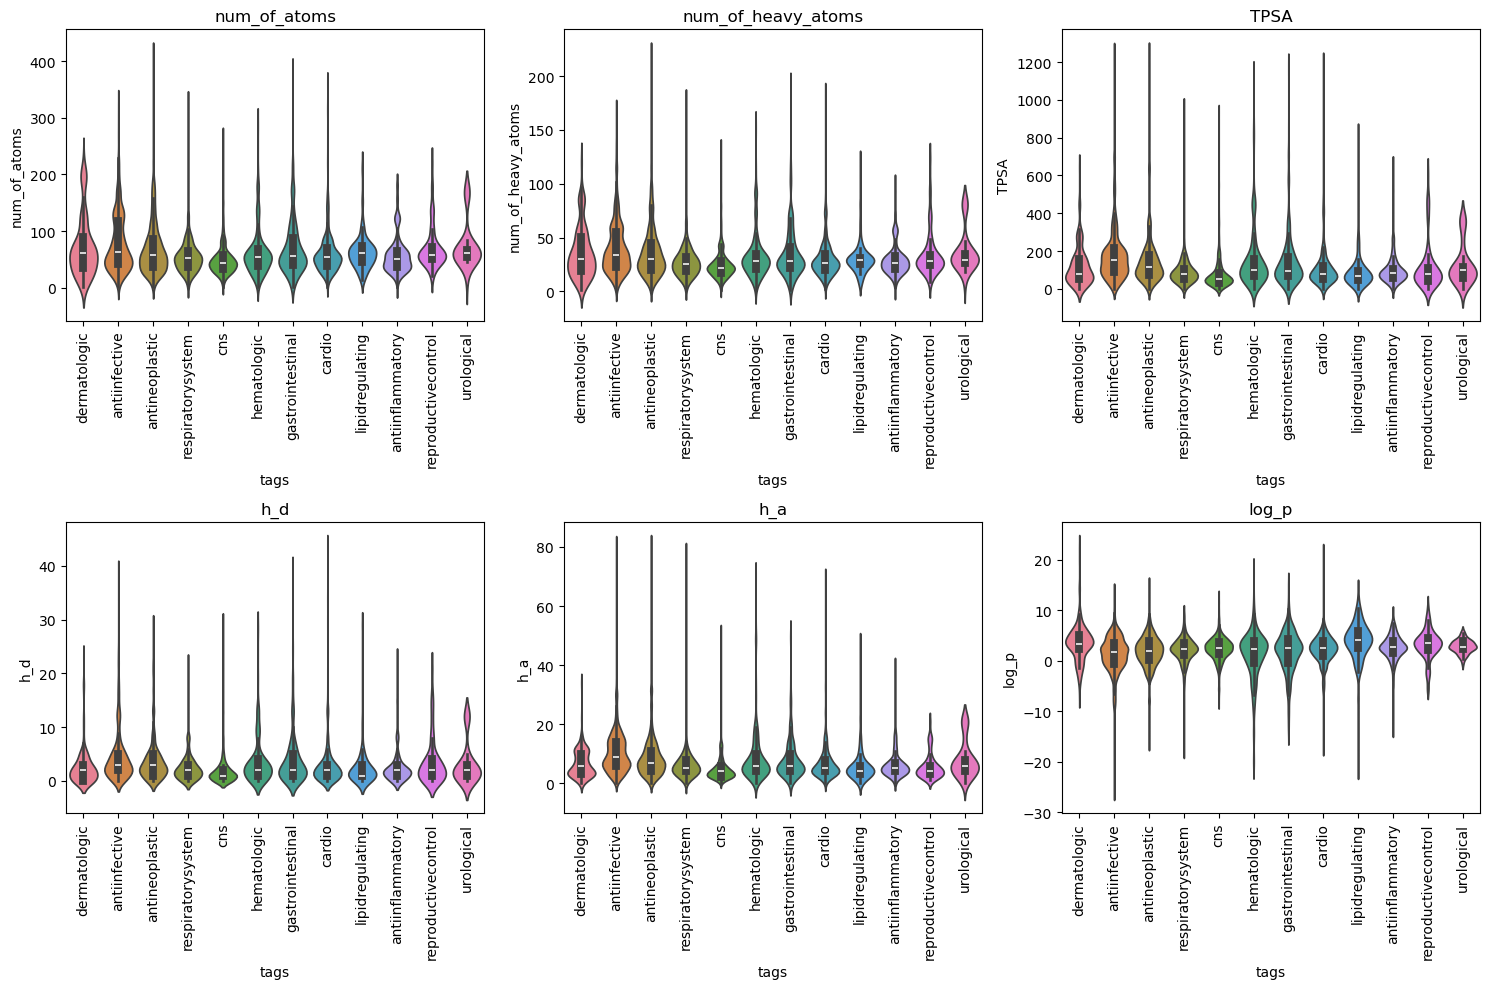

In [9]:
features = ["num_of_atoms", "num_of_heavy_atoms", "TPSA", "h_d", "h_a", "log_p"]
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.violinplot(x="tags", y=feature, data=data, hue="tags", legend=False)
    plt.title(feature)
    plt.ylabel(feature)
    plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

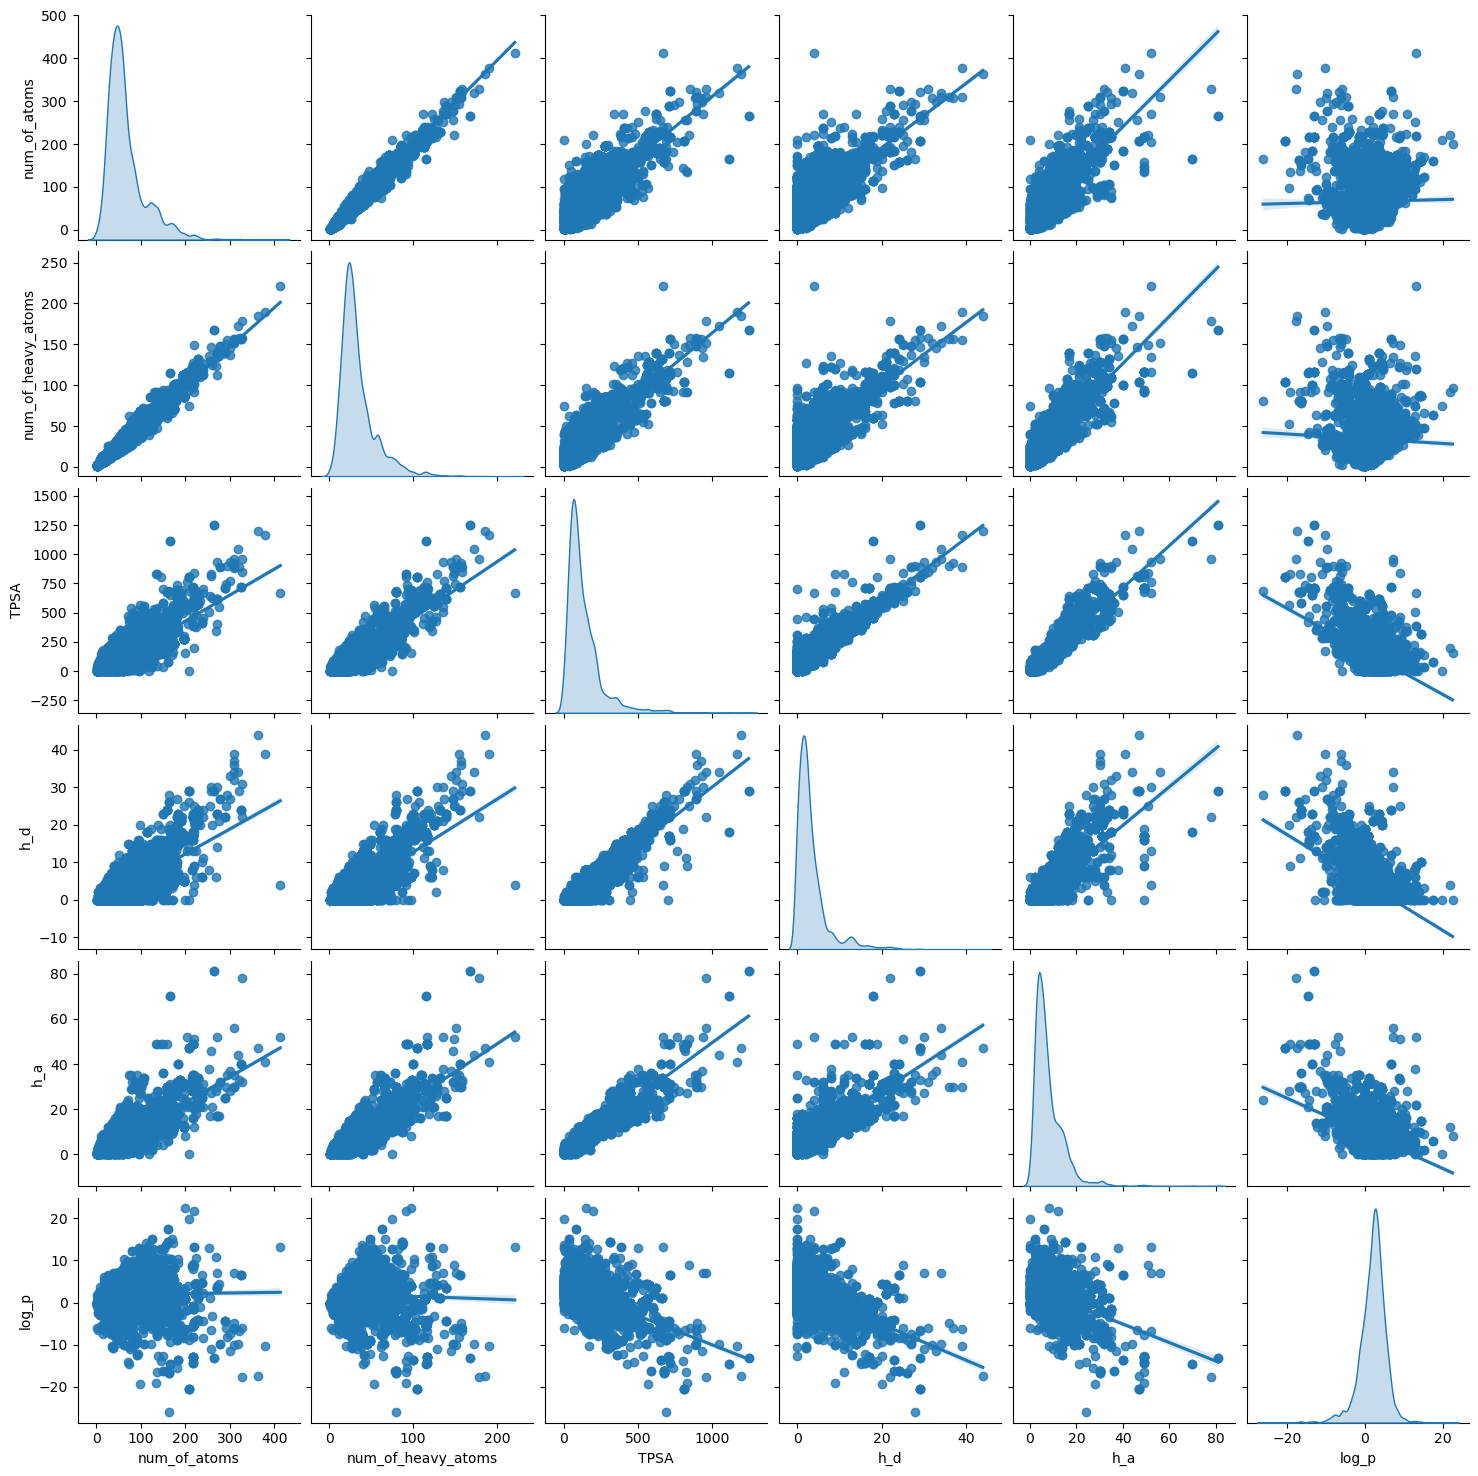

In [10]:
sns.pairplot(data[["num_of_atoms", "num_of_heavy_atoms", "TPSA", "h_d", "h_a", "log_p"]], diag_kind="kde", kind="reg")
plt.show()

Fingerprints

In [11]:
data_mol = []
for _, smiles in data["smiles"].items():
    data_mol.append(Chem.MolFromSmiles(smiles))

In [12]:
rdkitGen = rdFingerprintGenerator.GetMorganGenerator(radius = 2, fpSize = 1024)
data_fingerprints = [rdkitGen.GetFingerprint(mol) for mol in data_mol]

print(f"Number of compounds (activity unknown)) converted: {len(data_fingerprints)}")
print(f"Fingerprint length per compound: {len(data_fingerprints[0])}")

Number of compounds (activity unknown)) converted: 9881
Fingerprint length per compound: 1024


In [13]:
def tanimotoDistanceMatrix(fpList):
    """
    generate Tanimoto distance matrix
    input: list of fingerprints
    output: matrix of distances between each molecule
    """
    dissimilarityMatrix = []
    for i in range (1, len(fpList)):
        similarities = DataStructs.BulkTanimotoSimilarity(fpList[i], fpList[:i])
        dissimilarityMatrix.extend([1 - x for x in similarities])
    return dissimilarityMatrix

def clusterFingerprints(fingerprints, cutoff):
    """cluster fingerprints using Butina based on pre-set cutoff
    input: list of fingerprints, cutoff[0;1]
    output: a tuple of tuples containing information about the clusters; first element for each cluster is its centroid
    *higher cutoff = less clusters, bigger diversity within a cluster
    """
    distanceMatrix = tanimotoDistanceMatrix(fingerprints)
    clusters = Butina.ClusterData(distanceMatrix, len(fingerprints), cutoff, isDistData = True)
    clusters = sorted(clusters, key = len, reverse = True)
    return clusters

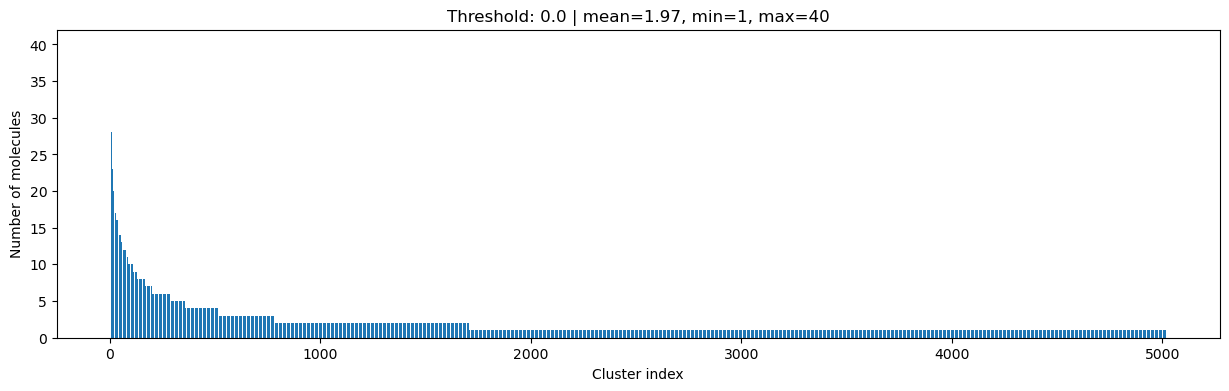

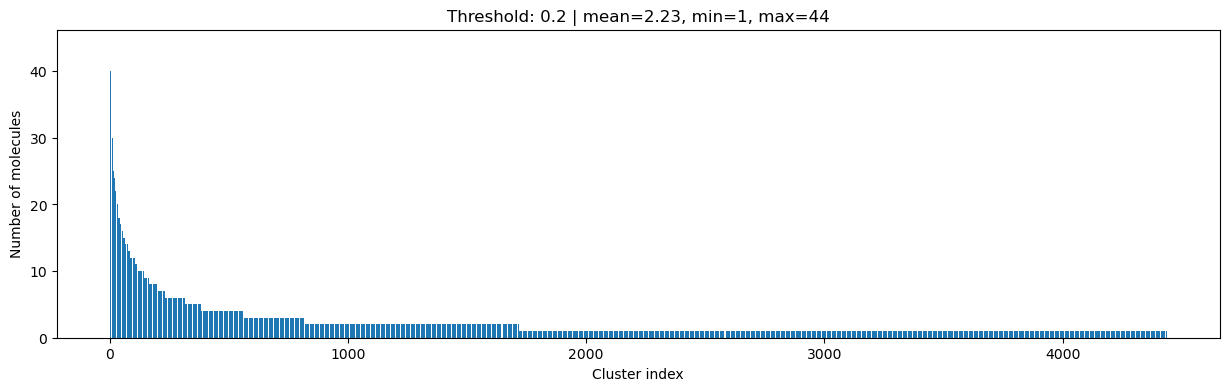

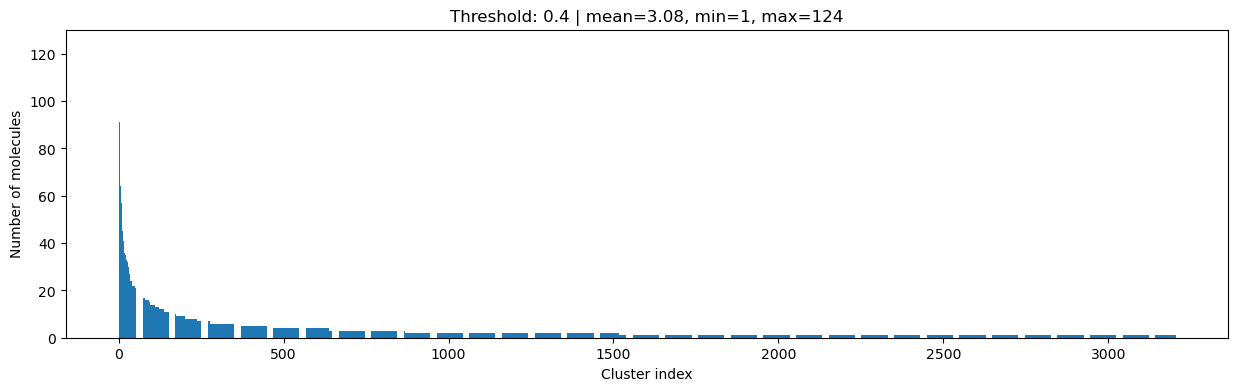

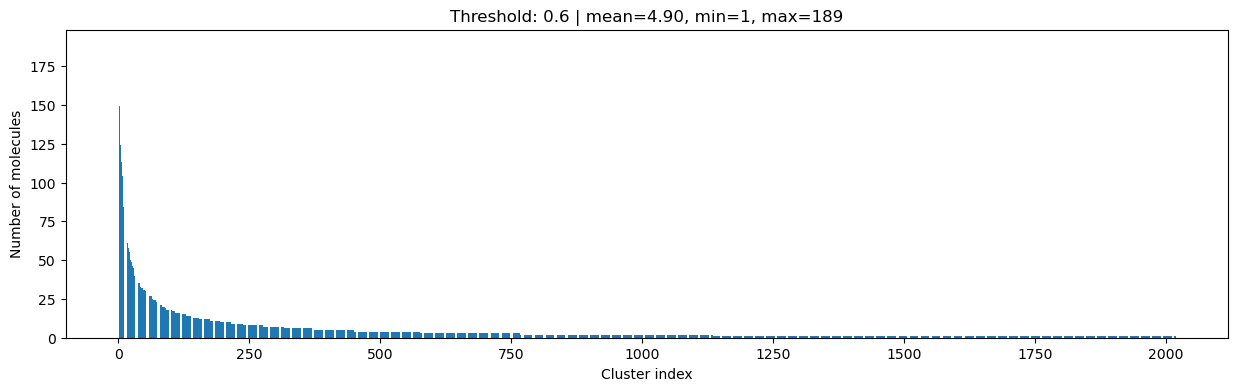

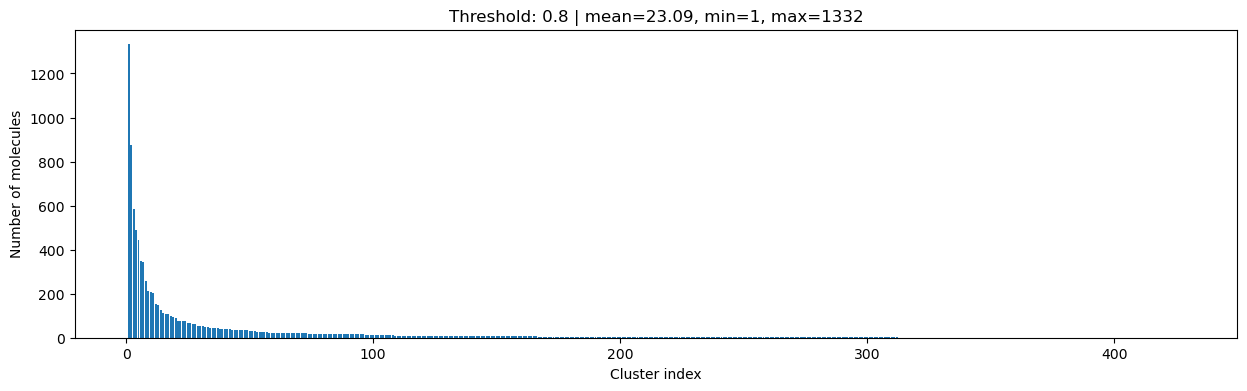

In [19]:
for cutoff in np.arange(0.0, 1.0, 0.2):
    clusters = clusterFingerprints(data_fingerprints, cutoff=cutoff)
    sizes = np.array([len(c) for c in clusters])
    
    fig, ax = plt.subplots(figsize=(15, 4))
    ax.set_title(f"Threshold: {cutoff:2.1f} | mean={sizes.mean():.2f}, min={sizes.min()}, max={sizes.max()}")
    ax.set_xlabel("Cluster index")
    ax.set_ylabel("Number of molecules")
    ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5)